In [1]:
import matplotlib.pyplot as plt
import numpy as np  

import brainpy as bp
import brainpy.math as bm

from func_brainpy_model import DecoModel, outLinear, DecoModel_v1

In [2]:
# 没有想好怎么写
class outBalloon(bp.DynamicalSystemNS):
    def __init__(
        self,
        size: int,
        batch_size: int,
        V0: float = None,
        K1: float = None, 
        K2: float = None, 
        K3: float = None, 
        ):

        super(outBalloon, self).__init__()
        '''
        Output-nonlinear-scalling-layer (Balloon dynamics) of S from RNN-layer DecoModel
        size = num, i.e., number of network size (# of node)
        '''

In [3]:
# brainpy setting
bm.set_platform('cpu')
print('bp version: ', bp.__version__)
bm.set_mode(bm.batching_mode)
bm.dt = 5e-4 # second; 2000Hz sample rate
bm.random.seed(123)

bp version:  2.4.5.post5


In [4]:
# get structural connectivity
N = 10
sc = bm.random.rand(N,N)
sc = (sc+sc.T)/2
sc = sc-bm.diag(bm.diag(sc))

In [5]:
# stack our model
class myModel(bp.DynamicalSystemNS):
    def __init__(self,size,struc_conn_matrix,G,w,I,):
        super(myModel, self).__init__()

        self.rnnLayer = DecoModel(size=N, struc_conn_matrix=sc, G=G, w=w, I=I,)
        self.outLayer = outLinear(size=N, a=bm.ones(1),b=bm.zeros(1))
        # self.outLayer = outBalloon(size=N,)
        # self.outLayer = outLFP(size=N,)

    def update(self, x = 0):
        s = self.rnnLayer(x)
        z = self.outLayer(s)
        return z

In [6]:
# set parameter and model
G = 0.1

case = 1
if case == 1: # homogeneous deco model
    w = bm.asarray(0.5)
    I = bm.asarray(0.5)
elif case == 2: # Heterogeneous deco model with same initialization
    w = 0.5
    I = 0.5
elif case == 3: # Heterogeneous deco model with rand initialization
    w = bm.random.rand(N)
    I = bm.random.rand(N)

#model = myModel(size=N, struc_conn_matrix=sc, G=G, w=w, I=I,)
model = DecoModel_v1(size = N, struc_conn_matrix=sc, G=G, w=w, I=I,)

#for i in model.vars():
#    print(i,' -> ',model.vars()[i])

In [7]:
# running resting-state simulation with noise input

# get noise input 
sigma = 1 
duration = 10 #seconds
noise = sigma*bm.random.randn(1,int(duration/bm.dt),N)*bm.sqrt(bm.dt)

# running
runner = bp.DSRunner(model, progress_bar=False,)
out_data = runner.run(inputs = noise)[0,:,:]
ts = runner.mon.ts

# get functional connectivity
fc = bp.measure.functional_connectivity(out_data[2000:,:])
fc = fc - bm.diag(bm.diag(fc)) 

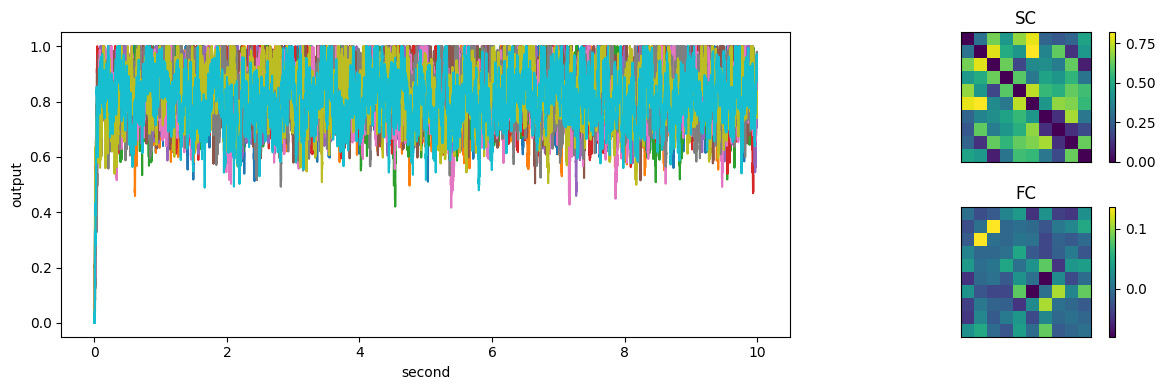

In [8]:
# plotting
fig = plt.figure(figsize=(12,4))

ax1 = plt.subplot2grid((2, 3), (0, 0), rowspan=2, colspan=2)
ax1.plot(ts , out_data )
ax1.set_ylabel('output')
ax1.set_xlabel('second')

ax2 = plt.subplot2grid((2, 3), (0, 2), rowspan=1, colspan=1)
img = ax2.imshow(sc)
ax2.set_title('SC')
ax2.set_xticks([])
ax2.set_yticks([])
plt.colorbar(img)

ax3 = plt.subplot2grid((2, 3), (1, 2), rowspan=1, colspan=1)
img = ax3.imshow(fc)
ax3.set_title('FC')
ax3.set_xticks([])
ax3.set_yticks([])
plt.colorbar(img)

plt.tight_layout()
plt.show()
